<a href="https://colab.research.google.com/github/kanpiromnida-cmd/madt6004-applied-stat/blob/main/customer_synthetic_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Analytics (Synthetic Data) — Cleaning + Statistical Tests  
**Unit of analysis:** 1 row = 1 customer  

This notebook will:
1) Create mockup customer-level data (`df`)  
2) Intentionally add some dirty data (missing values, outliers, invalid categories)  
3) Clean the data into `df_clean`  
4) Run statistical tests to see whether customer groups differ  
5) Summarize findings in plain language (Thai)

> ✅ All code is runnable in Google Colab.


## 1) Setup & Imports

In [1]:
# If running in a fresh Colab runtime, these are usually already available.
# !pip -q install numpy pandas matplotlib seaborn scipy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Make plots look consistent
sns.set_context("notebook")

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 50)


## 2) Data Generation (Mockup)

In [2]:
def generate_synthetic_customers(n_customers: int = 4000, seed: int = 42) -> pd.DataFrame:
    """Generate a synthetic customer-level dataset with realistic relationships + intentional 'dirty' data.

    Relationships:
    - avg_ticket_size is higher for higher membership_tier (Gold > Silver > Bronze)
    - avg_visit_per_month is higher for Old customers
    - payment_method distribution varies by age_group (younger -> more E-Wallet)

    Dirty data introduced:
    - random missing values in numeric + categorical fields
    - outliers in avg_ticket_size and avg_visit_per_month
    - invalid categories (gender='Unknown', payment_method='NA', membership_tier='Platinum')
    """
    rng = np.random.default_rng(seed)

    # -------------------------
    # Categorical generation
    # -------------------------
    age_groups = ["Teen", "Young Adult", "Adult", "Senior"]
    age_probs  = [0.10, 0.35, 0.40, 0.15]
    age_group = rng.choice(age_groups, size=n_customers, p=age_probs)

    genders = ["Male", "Female", "Other"]
    gender_probs = [0.48, 0.50, 0.02]
    gender = rng.choice(genders, size=n_customers, p=gender_probs)

    customer_type = rng.choice(["New", "Old"], size=n_customers, p=[0.35, 0.65])

    # Membership: typically more Bronze than Silver than Gold
    membership_tier = rng.choice(["Bronze", "Silver", "Gold"], size=n_customers, p=[0.55, 0.30, 0.15])

    # Payment method depends on age group (example behavior)
    # (Teen/Young Adult -> more E-Wallet, Senior -> more Cash)
    payment_map = {
        "Teen":        (["Cash", "Credit Card", "E-Wallet", "Bank Transfer"], [0.15, 0.10, 0.70, 0.05]),
        "Young Adult": (["Cash", "Credit Card", "E-Wallet", "Bank Transfer"], [0.15, 0.25, 0.55, 0.05]),
        "Adult":       (["Cash", "Credit Card", "E-Wallet", "Bank Transfer"], [0.20, 0.40, 0.35, 0.05]),
        "Senior":      (["Cash", "Credit Card", "E-Wallet", "Bank Transfer"], [0.55, 0.30, 0.10, 0.05]),
    }
    payment_method = np.empty(n_customers, dtype=object)
    for i, ag in enumerate(age_group):
        opts, probs = payment_map[ag]
        payment_method[i] = rng.choice(opts, p=probs)

    # -------------------------
    # Numeric generation
    # -------------------------
    # avg_ticket_size (THB): use lognormal to mimic spending distribution (right-skew)
    # base spending differs by tier
    tier_base = {"Bronze": 220, "Silver": 290, "Gold": 380}  # scale-ish (not exact mean)

    # Generate base with lognormal noise
    base = np.array([tier_base[t] for t in membership_tier])
    # lognormal with moderate variance
    ticket_noise = rng.lognormal(mean=0.0, sigma=0.35, size=n_customers)
    avg_ticket_size = base * ticket_noise

    # avg_visit_per_month: Old customers visit more often (Poisson + small noise)
    # We'll generate a lambda that depends on customer_type and membership
    # (membership can also slightly increase visits, realistic loyalty effect)
    cust_lambda = np.where(customer_type == "Old", 3.2, 2.2)  # Old > New
    tier_visit_boost = np.select(
        [membership_tier == "Gold", membership_tier == "Silver", membership_tier == "Bronze"],
        [0.5, 0.3, 0.0],
        default=0.0
    )
    lam = np.clip(cust_lambda + tier_visit_boost, 0.5, None)
    avg_visit_per_month = rng.poisson(lam=lam, size=n_customers).astype(float)
    # Add mild continuous noise so it isn't all integers
    avg_visit_per_month += rng.normal(loc=0.0, scale=0.25, size=n_customers)
    avg_visit_per_month = np.clip(avg_visit_per_month, 0.0, None)

    df = pd.DataFrame({
        "avg_ticket_size": avg_ticket_size.round(2),
        "avg_visit_per_month": avg_visit_per_month.round(2),
        "age_group": age_group,
        "gender": gender,
        "customer_type": customer_type,
        "payment_method": payment_method,
        "membership_tier": membership_tier
    })

    # -------------------------
    # Introduce dirty data
    # -------------------------
    # 1) Random missing values
    # NOTE: we intentionally add missingness to simulate real-world messy data.
    missing_rate_num = 0.04
    missing_rate_cat = 0.03

    for col in ["avg_ticket_size", "avg_visit_per_month"]:
        mask = rng.random(n_customers) < missing_rate_num
        df.loc[mask, col] = np.nan

    for col in ["age_group", "gender", "customer_type", "payment_method", "membership_tier"]:
        mask = rng.random(n_customers) < missing_rate_cat
        df.loc[mask, col] = np.nan

    # 2) Outliers (extreme values)
    # Increase a small fraction with very large ticket size and visits
    outlier_rate = 0.01
    out_idx = rng.choice(df.index, size=int(n_customers * outlier_rate), replace=False)
    df.loc[out_idx, "avg_ticket_size"] = df.loc[out_idx, "avg_ticket_size"] * rng.uniform(4, 8, size=len(out_idx))

    out_idx2 = rng.choice(df.index, size=int(n_customers * outlier_rate), replace=False)
    df.loc[out_idx2, "avg_visit_per_month"] = df.loc[out_idx2, "avg_visit_per_month"] + rng.uniform(10, 25, size=len(out_idx2))

    # 3) Invalid categories
    # Gender invalid: 'Unknown' (not in allowed set)
    inv_gender_rate = 0.01
    inv_idx = rng.choice(df.index, size=int(n_customers * inv_gender_rate), replace=False)
    df.loc[inv_idx, "gender"] = "Unknown"

    # Payment invalid: 'NA'
    inv_pay_rate = 0.008
    inv_idx = rng.choice(df.index, size=int(n_customers * inv_pay_rate), replace=False)
    df.loc[inv_idx, "payment_method"] = "NA"

    # Membership invalid: 'Platinum'
    inv_tier_rate = 0.006
    inv_idx = rng.choice(df.index, size=int(n_customers * inv_tier_rate), replace=False)
    df.loc[inv_idx, "membership_tier"] = "Platinum"

    return df

# Create dataset
df = generate_synthetic_customers(n_customers=4200, seed=RANDOM_SEED)

df.head()


,avg_ticket_size,avg_visit_per_month,age_group,gender,customer_type,payment_method,membership_tier
0,144.16,5.70,Adult,Male,Old,Credit Card,Silver
1,679.99,2.66,Young Adult,Female,New,E-Wallet,Gold
2,334.10,4.11,Senior,NaN,Old,NaN,Gold
3,177.22,6.33,Adult,Female,Old,E-Wallet,Bronze
4,353.87,0.76,Teen,Female,Old,Cash,Bronze


In [3]:
# Basic structure checks
print("df.shape =", df.shape)
display(df.info())


df.shape = (4200, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   avg_ticket_size      4033 non-null   float64
 1   avg_visit_per_month  4015 non-null   float64
 2   age_group            4077 non-null   object 
 3   gender               4077 non-null   object 
 4   customer_type        4093 non-null   object 
 5   payment_method       4064 non-null   object 
 6   membership_tier      4079 non-null   object 
dtypes: float64(2), object(5)
memory usage: 229.8+ KB


None

In [4]:
# Numeric summary
df.describe()


,avg_ticket_size,avg_visit_per_month
count,4033.000000,4015.000000
mean,299.425796,3.253724
std,214.695472,2.659680
min,72.080000,0.000000
25%,199.470000,1.820000
50%,262.410000,2.930000
75%,344.990000,4.190000
max,3884.479830,31.220982


In [5]:
# Categorical value counts (top 10 to keep output tidy)
cat_cols = ["age_group", "gender", "customer_type", "payment_method", "membership_tier"]
for c in cat_cols:
    print(f"\n--- {c} ---")
    display(df[c].value_counts(dropna=False).head(10))



--- age_group ---


,count
age_group,
Adult,1612
Young Adult,1439
Senior,618
Teen,408
NaN,123



--- gender ---


,count
gender,
Female,1983
Male,1976
NaN,123
Other,76
Unknown,42



--- customer_type ---


,count
customer_type,
Old,2664
New,1429
NaN,107



--- payment_method ---


,count
payment_method,
E-Wallet,1762
Credit Card,1154
Cash,906
Bank Transfer,209
NaN,136
NA,33



--- membership_tier ---


,count
membership_tier,
Bronze,2188
Silver,1256
Gold,610
NaN,121
Platinum,25


## 3) Data Cleaning

In [6]:
# We'll clean data into df_clean and keep df as the 'raw/dirty' version.
df_raw = df.copy()

# Allowed categories
VALID_GENDER = {"Male", "Female", "Other"}
VALID_PAYMENT = {"Cash", "Credit Card", "E-Wallet", "Bank Transfer"}
VALID_TIER = {"Gold", "Silver", "Bronze"}
VALID_AGE = {"Teen", "Young Adult", "Adult", "Senior"}
VALID_CTYPE = {"New", "Old"}

def clean_categories(s: pd.Series, valid_set: set, unknown_label: str = "Unknown") -> pd.Series:
    """Replace invalid categories and missing values with a safe label."""
    s2 = s.copy()
    s2 = s2.fillna(unknown_label)
    s2 = s2.where(s2.isin(valid_set), other=unknown_label)
    return s2

# 1) Fix invalid categories + fill missing categoricals.
df_cat = df_raw.copy()
df_cat["gender"] = clean_categories(df_cat["gender"], VALID_GENDER, unknown_label="Unknown")
df_cat["payment_method"] = clean_categories(df_cat["payment_method"], VALID_PAYMENT, unknown_label="Unknown")
df_cat["membership_tier"] = clean_categories(df_cat["membership_tier"], VALID_TIER, unknown_label="Unknown")
df_cat["age_group"] = clean_categories(df_cat["age_group"], VALID_AGE, unknown_label="Unknown")
df_cat["customer_type"] = clean_categories(df_cat["customer_type"], VALID_CTYPE, unknown_label="Unknown")

# 2) Handle missing numeric values.
# Decision:
# - We'll impute numeric missing values with MEDIAN because:
#   a) spending/visits can be skewed (median is robust),
#   b) dropping rows may reduce sample size and can bias group comparisons.
df_num = df_cat.copy()
for col in ["avg_ticket_size", "avg_visit_per_month"]:
    median_val = df_num[col].median(skipna=True)
    df_num[col] = df_num[col].fillna(median_val)

# 3) Outlier handling (IQR capping / winsorization)
# Decision:
# - We'll CAP (winsorize) extreme values instead of removing customers,
#   to preserve customer count and avoid deleting potentially valid 'high value' customers.
def iqr_cap(series: pd.Series, k: float = 1.5) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    capped = series.clip(lower=lower, upper=upper)
    return capped

df_clean = df_num.copy()
df_clean["avg_ticket_size"] = iqr_cap(df_clean["avg_ticket_size"], k=1.5)
df_clean["avg_visit_per_month"] = iqr_cap(df_clean["avg_visit_per_month"], k=1.5)

# Final check
print("df_raw.shape  =", df_raw.shape)
print("df_clean.shape=", df_clean.shape)

df_clean.head()


df_raw.shape  = (4200, 7)
df_clean.shape= (4200, 7)


,avg_ticket_size,avg_visit_per_month,age_group,gender,customer_type,payment_method,membership_tier
0,144.16000,5.70,Adult,Male,Old,Credit Card,Silver
1,547.26375,2.66,Young Adult,Female,New,E-Wallet,Gold
2,334.10000,4.11,Senior,Unknown,Old,Unknown,Gold
3,177.22000,6.33,Adult,Female,Old,E-Wallet,Bronze
4,353.87000,0.76,Teen,Female,Old,Cash,Bronze


In [7]:
# Before/after summary statistics (numeric)
num_cols = ["avg_ticket_size", "avg_visit_per_month"]

print("=== BEFORE (raw) ===")
display(df_raw[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

print("=== AFTER (clean) ===")
display(df_clean[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))


=== BEFORE (raw) ===


,avg_ticket_size,avg_visit_per_month
count,4033.000000,4015.000000
mean,299.425796,3.253724
std,214.695472,2.659680
min,72.080000,0.000000
1%,104.712400,0.000000
5%,138.288000,0.280000
50%,262.410000,2.930000
95%,529.058000,6.813000
99%,928.691200,12.197931
max,3884.479830,31.220982


=== AFTER (clean) ===


,avg_ticket_size,avg_visit_per_month
count,4200.000000,4200.000000
mean,281.894255,3.087073
std,108.530502,1.804855
min,72.080000,0.000000
1%,104.769900,0.000000
5%,139.424000,0.310000
50%,262.410000,2.930000
95%,525.764000,6.740500
99%,547.263750,7.535000
max,547.263750,7.535000


In [8]:
# Before/after invalid categories check (quick sanity)
for c in ["gender", "payment_method", "membership_tier"]:
    print(f"\n--- {c} (raw) ---")
    display(df_raw[c].value_counts(dropna=False).head(10))
    print(f"--- {c} (clean) ---")
    display(df_clean[c].value_counts(dropna=False).head(10))



--- gender (raw) ---


,count
gender,
Female,1983
Male,1976
NaN,123
Other,76
Unknown,42


--- gender (clean) ---


,count
gender,
Female,1983
Male,1976
Unknown,165
Other,76



--- payment_method (raw) ---


,count
payment_method,
E-Wallet,1762
Credit Card,1154
Cash,906
Bank Transfer,209
NaN,136
NA,33


--- payment_method (clean) ---


,count
payment_method,
E-Wallet,1762
Credit Card,1154
Cash,906
Bank Transfer,209
Unknown,169



--- membership_tier (raw) ---


,count
membership_tier,
Bronze,2188
Silver,1256
Gold,610
NaN,121
Platinum,25


--- membership_tier (clean) ---


,count
membership_tier,
Bronze,2188
Silver,1256
Gold,610
Unknown,146


## 4) Exploratory Analysis

In [9]:
# Quick group summaries to visually confirm behavior
# 1) avg_ticket_size should be higher for higher membership tier (Gold > Silver > Bronze)
display(
    df_clean.groupby("membership_tier")[["avg_ticket_size", "avg_visit_per_month"]]
    .agg(["mean", "median", "count"])
    .sort_index()
)

# 2) avg_visit_per_month should be higher for Old customers
display(
    df_clean.groupby("customer_type")[["avg_visit_per_month", "avg_ticket_size"]]
    .agg(["mean", "median", "count"])
)

# 3) Payment method distribution by age_group
pm_age = pd.crosstab(df_clean["age_group"], df_clean["payment_method"], normalize="index").round(3)
display(pm_age)


avg_ticket_size                avg_visit_per_month         \
                           mean   median count                mean median   
membership_tier                                                             
Bronze               238.339602  226.105  2188            2.923985   2.89   
Gold                 383.538936  376.955   610            3.317369   3.01   
Silver               307.423966  287.885  1256            3.271696   3.00   
Unknown              290.312106  262.410   146            2.980685   2.93   

                       
                count  
membership_tier        
Bronze           2188  
Gold              610  
Silver           1256  
Unknown           146

avg_visit_per_month              avg_ticket_size              
                             mean median count            mean  median count
customer_type                                                               
New                      2.462621  2.260  1429      282.932182  262.41  1429
Old                      3.415790  3.135  2664      281.208016  262.41  2664
Unknown                  3.242570  2.930   107      285.118026  265.00   107

payment_method,Bank Transfer,Cash,Credit Card,E-Wallet,Unknown
age_group,,,,,
Adult,0.045,0.177,0.375,0.361,0.041
Senior,0.063,0.490,0.293,0.102,0.052
Teen,0.037,0.157,0.093,0.681,0.032
Unknown,0.041,0.252,0.211,0.472,0.024
Young Adult,0.054,0.154,0.211,0.543,0.038


## 5) Statistical Tests

In [10]:
# Helper: choose parametric vs non-parametric test based on quick assumption checks.
# NOTE: With large samples, normality tests can be overly sensitive.
# We'll do a simple approach:
# - If each group has >= 30 and Levene's test indicates equal variance (p>0.05),
#   we'll *consider* ANOVA / t-test.
# - Otherwise use Kruskal / Mann-Whitney.

def levene_pvalue(groups):
    return stats.levene(*groups, center="median").pvalue

def normaltest_pvalue(x):
    # D'Agostino and Pearson’s normality test (works for n >= 8)
    x = np.asarray(x)
    if len(x) < 8:
        return np.nan
    return stats.normaltest(x).pvalue

results = {}  # store test name + p-value for final summary

# -----------------------------
# (1) avg_ticket_size by membership_tier (3 groups)
# -----------------------------
tiers_to_compare = ["Gold", "Silver", "Bronze"]
ticket_groups = [df_clean.loc[df_clean["membership_tier"] == t, "avg_ticket_size"].values for t in tiers_to_compare]

group_means = {t: float(np.mean(g)) for t, g in zip(tiers_to_compare, ticket_groups)}
print("Group means (avg_ticket_size):")
for k, v in group_means.items():
    print(f"  {k:6s} = {v:,.2f} THB")

lev_p = levene_pvalue(ticket_groups)
norm_ps = [normaltest_pvalue(g) for g in ticket_groups]

print(f"\nLevene test p-value (variance equality): {lev_p:.4g}")
print("Normality test p-values per group:", dict(zip(tiers_to_compare, [None if np.isnan(p) else round(p, 4) for p in norm_ps])))

use_anova = (lev_p > 0.05) and all([(p is not None) and (p > 0.05) for p in norm_ps if not np.isnan(p)])
# In practice, spending is often skewed; Kruskal is usually safer.
# We'll still keep the logic above as an educational example.

if use_anova:
    test_name = "One-way ANOVA (scipy.stats.f_oneway)"
    stat, p = stats.f_oneway(*ticket_groups)
else:
    test_name = "Kruskal-Wallis (scipy.stats.kruskal)"
    stat, p = stats.kruskal(*ticket_groups)

print(f"\nChosen test: {test_name}")
print(f"Test statistic = {stat:.4g}, p-value = {p:.4g}")

results["ticket_by_tier"] = {"test": test_name, "p_value": float(p), "means": group_means}

# -----------------------------
# (2) avg_visit_per_month: New vs Old
# -----------------------------
vis_new = df_clean.loc[df_clean["customer_type"] == "New", "avg_visit_per_month"].values
vis_old = df_clean.loc[df_clean["customer_type"] == "Old", "avg_visit_per_month"].values

mean_new = float(np.mean(vis_new))
mean_old = float(np.mean(vis_old))
print("\nGroup means (avg_visit_per_month):")
print(f"  New = {mean_new:.2f}")
print(f"  Old = {mean_old:.2f}")

lev_p2 = stats.levene(vis_new, vis_old, center="median").pvalue
n_p_new = normaltest_pvalue(vis_new)
n_p_old = normaltest_pvalue(vis_old)

print(f"\nLevene test p-value: {lev_p2:.4g}")
print(f"Normality p-values: New={n_p_new:.4g}, Old={n_p_old:.4g}")

use_ttest = (lev_p2 > 0.05) and (n_p_new > 0.05) and (n_p_old > 0.05) and (len(vis_new) >= 30) and (len(vis_old) >= 30)

if use_ttest:
    test_name2 = "Independent t-test (Welch) (scipy.stats.ttest_ind)"
    stat2, p2 = stats.ttest_ind(vis_new, vis_old, equal_var=False)
else:
    test_name2 = "Mann-Whitney U (scipy.stats.mannwhitneyu)"
    stat2, p2 = stats.mannwhitneyu(vis_new, vis_old, alternative="two-sided")

print(f"\nChosen test: {test_name2}")
print(f"Test statistic = {stat2:.4g}, p-value = {p2:.4g}")

results["visits_new_vs_old"] = {
    "test": test_name2,
    "p_value": float(p2),
    "means": {"New": mean_new, "Old": mean_old}
}

# -----------------------------
# (3) Optional: avg_ticket_size by age_group (4 groups)
# -----------------------------
age_levels = ["Teen", "Young Adult", "Adult", "Senior"]
ticket_age_groups = [df_clean.loc[df_clean["age_group"] == a, "avg_ticket_size"].values for a in age_levels]

age_means = {a: float(np.mean(g)) for a, g in zip(age_levels, ticket_age_groups)}
print("\nGroup means (avg_ticket_size) by age_group:")
for k, v in age_means.items():
    print(f"  {k:12s} = {v:,.2f} THB")

lev_p3 = levene_pvalue(ticket_age_groups)
norm_ps3 = [normaltest_pvalue(g) for g in ticket_age_groups]
use_anova3 = (lev_p3 > 0.05) and all([(p is not None) and (p > 0.05) for p in norm_ps3 if not np.isnan(p)])

if use_anova3:
    test_name3 = "One-way ANOVA (scipy.stats.f_oneway)"
    stat3, p3 = stats.f_oneway(*ticket_age_groups)
else:
    test_name3 = "Kruskal-Wallis (scipy.stats.kruskal)"
    stat3, p3 = stats.kruskal(*ticket_age_groups)

print(f"\nChosen test: {test_name3}")
print(f"Test statistic = {stat3:.4g}, p-value = {p3:.4g}")

results["ticket_by_age_group"] = {"test": test_name3, "p_value": float(p3), "means": age_means}

results


Group means (avg_ticket_size):
  Gold   = 383.54 THB
  Silver = 307.42 THB
  Bronze = 238.34 THB

Levene test p-value (variance equality): 3.933e-28
Normality test p-values per group: {'Gold': np.float64(0.0), 'Silver': np.float64(0.0), 'Bronze': np.float64(0.0)}

Chosen test: Kruskal-Wallis (scipy.stats.kruskal)
Test statistic = 929.6, p-value = 1.413e-202

Group means (avg_visit_per_month):
  New = 2.46
  Old = 3.42

Levene test p-value: 2.446e-10
Normality p-values: New=5.218e-22, Old=5.3e-18

Chosen test: Mann-Whitney U (scipy.stats.mannwhitneyu)
Test statistic = 1.322e+06, p-value = 1.406e-58

Group means (avg_ticket_size) by age_group:
  Teen         = 277.22 THB
  Young Adult  = 288.09 THB
  Adult        = 279.25 THB
  Senior       = 277.03 THB

Chosen test: Kruskal-Wallis (scipy.stats.kruskal)
Test statistic = 5.253, p-value = 0.1542


{'ticket_by_tier': {'test': 'Kruskal-Wallis (scipy.stats.kruskal)',
  'p_value': 1.412988850101198e-202,
  'means': {'Gold': 383.53893647540986,
   'Silver': 307.4239659633758,
   'Bronze': 238.33960247173752}},
 'visits_new_vs_old': {'test': 'Mann-Whitney U (scipy.stats.mannwhitneyu)',
  'p_value': 1.4058916801216155e-58,
  'means': {'New': 2.4626207137858644, 'Old': 3.4157901651651654}},
 'ticket_by_age_group': {'test': 'Kruskal-Wallis (scipy.stats.kruskal)',
  'p_value': 0.15420250146453787,
  'means': {'Teen': 277.2174387254902,
   'Young Adult': 288.08554725503825,
   'Adult': 279.25253812541047,
   'Senior': 277.0335962783172}}}

## 6) Visualization

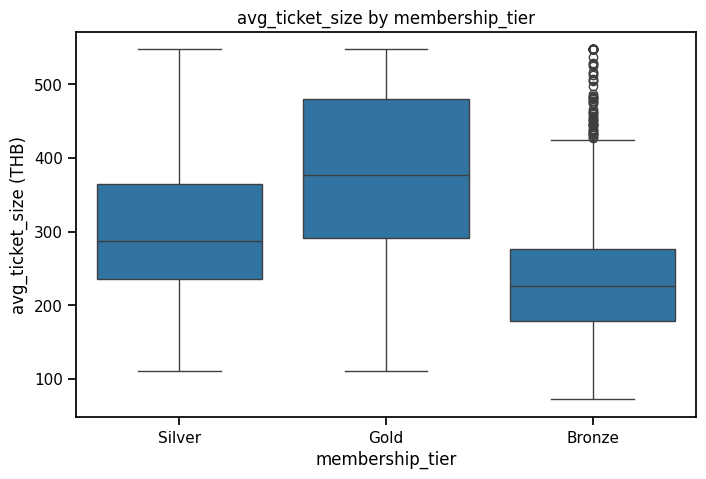

In [11]:
# Boxplot: avg_ticket_size by membership_tier
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clean[df_clean["membership_tier"].isin(["Bronze", "Silver", "Gold"])],
            x="membership_tier", y="avg_ticket_size")
plt.title("avg_ticket_size by membership_tier")
plt.xlabel("membership_tier")
plt.ylabel("avg_ticket_size (THB)")
plt.show()


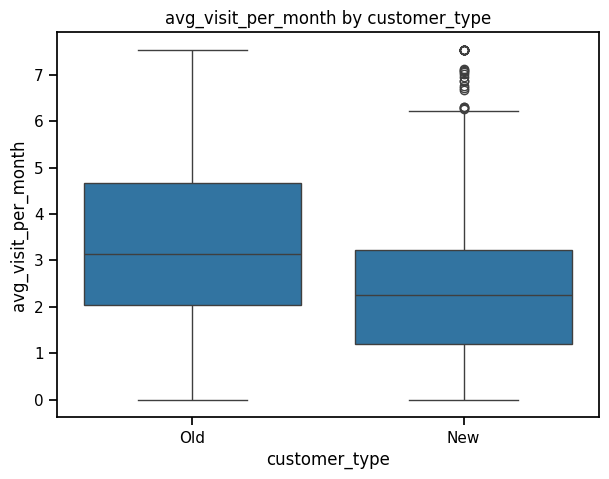

In [12]:
# Boxplot: avg_visit_per_month by customer_type
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_clean[df_clean["customer_type"].isin(["New", "Old"])],
            x="customer_type", y="avg_visit_per_month")
plt.title("avg_visit_per_month by customer_type")
plt.xlabel("customer_type")
plt.ylabel("avg_visit_per_month")
plt.show()


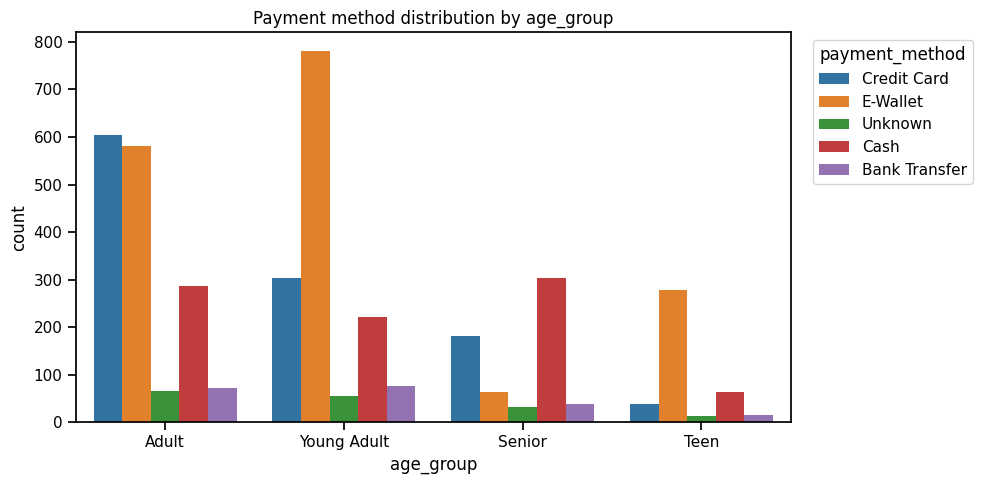

In [13]:
# Countplot: payment_method by age_group
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean[df_clean["age_group"].isin(["Teen","Young Adult","Adult","Senior"])],
              x="age_group", hue="payment_method")
plt.title("Payment method distribution by age_group")
plt.xlabel("age_group")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.legend(title="payment_method", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


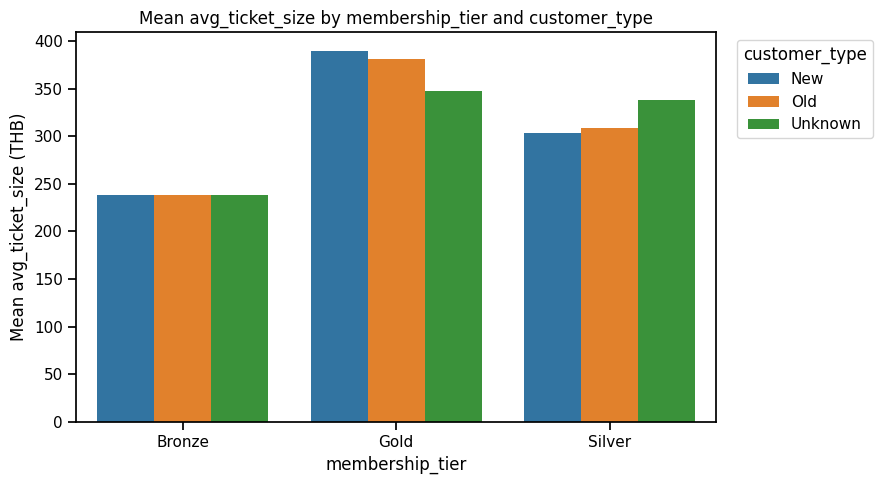

,membership_tier,customer_type,avg_ticket_size
0,Bronze,New,238.305597
1,Bronze,Old,238.338116
2,Bronze,Unknown,238.791186
3,Gold,New,389.560244
4,Gold,Old,381.384166
5,Gold,Unknown,347.272885
6,Silver,New,302.975140
7,Silver,Old,308.660736
8,Silver,Unknown,338.116797


In [14]:
# Extra visual check: average ticket by tier and customer_type (barplot)
tmp = (
    df_clean[df_clean["membership_tier"].isin(["Bronze", "Silver", "Gold"])]
    .groupby(["membership_tier", "customer_type"], as_index=False)["avg_ticket_size"].mean()
)

plt.figure(figsize=(9, 5))
sns.barplot(data=tmp, x="membership_tier", y="avg_ticket_size", hue="customer_type")
plt.title("Mean avg_ticket_size by membership_tier and customer_type")
plt.xlabel("membership_tier")
plt.ylabel("Mean avg_ticket_size (THB)")
plt.legend(title="customer_type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

display(tmp)


## 7) Summary & Interpretation

In [15]:
# Utility to format p-values nicely
def p_fmt(p):
    if p < 1e-4:
        return "< 0.0001"
    return f"{p:.4f}"

def sig_label(p, alpha=0.05):
    return "มีนัยสำคัญ" if p < alpha else "ไม่มีนัยสำคัญ"

# Pull results
p1 = results["ticket_by_tier"]["p_value"]
t1 = results["ticket_by_tier"]["test"]
m1 = results["ticket_by_tier"]["means"]

p2 = results["visits_new_vs_old"]["p_value"]
t2 = results["visits_new_vs_old"]["test"]
m2 = results["visits_new_vs_old"]["means"]

p3 = results["ticket_by_age_group"]["p_value"]
t3 = results["ticket_by_age_group"]["test"]
m3 = results["ticket_by_age_group"]["means"]

print("""\
==============================
สรุปผล (Summary) — แบบอ่านง่าย
==============================
""")

print("-" * 60)
print(f"• ทดสอบความแตกต่างของ avg_ticket_size ตาม membership_tier ด้วย: {t1}")
print(f"  - p-value = {p_fmt(p1)} → {sig_label(p1)} (alpha=0.05)")
print("  - ค่าเฉลี่ยโดยประมาณ (THB):")
for k, v in m1.items():
    print(f"    - {k}: {v:,.2f}")

print("\n" + "-" * 60)
print(f"• ทดสอบความแตกต่างของ avg_visit_per_month ระหว่าง New vs Old ด้วย: {t2}")
print(f"  - p-value = {p_fmt(p2)} → {sig_label(p2)} (alpha=0.05)")
print("  - ค่าเฉลี่ยโดยประมาณ:")
for k, v in m2.items():
    print(f"    - {k}: {v:.2f} ครั้ง/เดือน")

print("\n" + "-" * 60)
print(f"• (เพิ่มเติม) ทดสอบความแตกต่างของ avg_ticket_size ตาม age_group ด้วย: {t3}")
print(f"  - p-value = {p_fmt(p3)} → {sig_label(p3)} (alpha=0.05)")
print("  - ค่าเฉลี่ยโดยประมาณ (THB):")
for k, v in m3.items():
    print(f"    - {k}: {v:,.2f}")

print("\n" + "-" * 60)
print("\nข้อเสนอเชิงธุรกิจ/การตลาด (Business/Marketing Implications):")
print("• ถ้า tier มีนัยสำคัญ: โฟกัส upsell/upgrade จาก Bronze → Silver → Gold โดยเน้น benefit ที่เพิ่ม AOV (avg_ticket_size)")
print("• ถ้า Old visit มากกว่า New อย่างมีนัยสำคัญ: ลงทุนกับ retention (เช่น loyalty, CRM, personalized offers) จะคุ้มกว่าแค่หาลูกค้าใหม่อย่างเดียว")
print("• ใช้ข้อมูล payment_method ตาม age_group เพื่อออกแบบโปรโมชันเฉพาะช่องทาง (เช่น E-Wallet cashback ในกลุ่มวัยรุ่น/วัยทำงาน)")


สรุปผล (Summary) — แบบอ่านง่าย

------------------------------------------------------------
• ทดสอบความแตกต่างของ avg_ticket_size ตาม membership_tier ด้วย: Kruskal-Wallis (scipy.stats.kruskal)
  - p-value = < 0.0001 → มีนัยสำคัญ (alpha=0.05)
  - ค่าเฉลี่ยโดยประมาณ (THB):
    - Gold: 383.54
    - Silver: 307.42
    - Bronze: 238.34

------------------------------------------------------------
• ทดสอบความแตกต่างของ avg_visit_per_month ระหว่าง New vs Old ด้วย: Mann-Whitney U (scipy.stats.mannwhitneyu)
  - p-value = < 0.0001 → มีนัยสำคัญ (alpha=0.05)
  - ค่าเฉลี่ยโดยประมาณ:
    - New: 2.46 ครั้ง/เดือน
    - Old: 3.42 ครั้ง/เดือน

------------------------------------------------------------
• (เพิ่มเติม) ทดสอบความแตกต่างของ avg_ticket_size ตาม age_group ด้วย: Kruskal-Wallis (scipy.stats.kruskal)
  - p-value = 0.1542 → ไม่มีนัยสำคัญ (alpha=0.05)
  - ค่าเฉลี่ยโดยประมาณ (THB):
    - Teen: 277.22
    - Young Adult: 288.09
    - Adult: 279.25
    - Senior: 277.03

------------------------------

---
### ✅ Checklist (สิ่งที่คุณควรเห็น)
- `df` มี missing values / outliers / invalid categories จริง  
- `df_clean` ถูกเติม missing + แก้ category + cap outliers  
- ค่าเฉลี่ย `avg_ticket_size` : Gold > Silver > Bronze  
- ค่าเฉลี่ย `avg_visit_per_month` : Old > New  
- มี boxplot / countplot ให้ตรวจด้วยตา  
